In this document we develop the necessary functions to apply the *Unbiased EnKBF*. Some of the functions are already computed and are taken from https://github.com/fangyuan-ksgk/Multilevel-Ensemble-Kalman-Bucy-Filter

The system that we are concerned with is:
\begin{align}
dX_t =& A X_t dt + R_1 dW_t,\\
dY_t =& H X_t dt + R_2 dV_t
\end{align}


Model settings: (Conditions that the model needs to satsify)
1. Signal of dimension 'dim', and the observtations are in dimension 'dim_o'
2. $x_0|y_0 \sim N(m_0,C_0)$
3. $R_1, R_2$ is symmetric
4. $R_1$ is commutable with $A$
5. $(A+A')$ is invertible
6. For convenience purpose the target function is $\varphi(x)=x^{1}$, where $x=(x^{1},x^{2},...,x^{dim})$

In this code, I will include the $A,R_1,R_2,H,m_0,C_0$ as parameter as well, so that it's easily scalable wrt any dimension dim.
Note that dim needs to be bigger than 1, as the matrix multiplication sign '@' in python doesn't support '*' in one dimension.

First the input value for $A,R1,R2,H,m_0,C_0$ need to be folded into one variable.
One need to specify the model in the cell below first.

If we where going to compare with the paper, there would be a difference in the notations of the equations: In the paper we use $C$ instead of $H$(observation matrix?), $R_1$ instead of $R_1^{\frac{1}{2}}$, and $R_2$ instead of $R_2^{\frac{1}{2}}$.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import progressbar
from scipy.optimize import fsolve
from scipy import linalg as la
from scipy.sparse import identity
from scipy.sparse import rand
from scipy.sparse import diags
from scipy.sparse import triu
## dim is dimension value
dim=5
dim_o=5
A1 = -rand(dim,dim,density=0.75).toarray()/5  #rand is a function that generates a random sparce matrix with entries
# between 0 and 1.
A2 = triu(A1, k=1).toarray()/(10) #Upper triangular matrix 
A = diags(np.random.normal(-0.5,0,dim),0).toarray()/50 + A2 - A2.T 
## we denote R1^{1/2},R2^{1/2} as R1,R2 repectively for convenience
## Non-Identity covariance matrix
R1=(identity(dim).toarray() + np.tri(dim,dim,1) - np.tri(dim,dim,-2))/5
R2=(identity(dim_o).toarray() + np.tri(dim_o,dim_o,1) - np.tri(dim_o,dim_o,-2))/5

H=rand(dim_o,dim,density=0.75).toarray()/20
m0=np.zeros(dim)+6
C0=identity(dim).toarray()
## Collection of input 
collection_input = [dim,dim_o,A,R1,R2,H,m0,C0]
#print(A,R1,H,R2,m0,C0)

Generation of the realization of the process and of the matrices of the model

In [7]:
"""M:We can simulate the UO process exactly as shown in 
Markov Processes 1st Edition An Introduction for Physical Scientists Eq. E-12.b
"""


def gen_data(T,l,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**l)
    I=identity(dim).toarray()
    #print(l)
    tau=1./2**(l)
    L=la.expm(A*tau)
    ## We are going to need W to be symmetric! 
    W=(R1@R1)@(la.inv(A+A.T)@(L@(L.T)-I))
    C=tau*H
    V=(R2@R2)*tau

    v=np.zeros((J+1,dim,1))
    z=np.zeros((J+1,dim_o,1))
    v[0]=np.random.multivariate_normal(m0,C0,(1)).T
    z[0]=np.zeros((dim_o,1))


    for j in range(J):
        ## truth
        #M: how do we know this is the truth? 
        v[j+1] = L@v[j] + np.random.multivariate_normal(np.zeros(dim),W,(1)).T
        ## observation
        z[j+1] = z[j] + C@v[j+1] + np.random.multivariate_normal(np.zeros(dim_o),V,(1)).T
        
    return([z,v])



"""
def gen_model(dim):
    ## dim is dimension value
    dim_o=dim
    A1 = -rand(dim,dim,density=0.75).toarray()/1
    A2 = triu(A1, k=1).toarray()/(cmm)
    A = diags(np.random.normal(-0.5,0,dim),0).toarray()/50 + A2 - A2.T
    ## we denote R1^{1/2},R2^{1/2} as R1,R2 repectively for convenience
    ## Non-Identity covariance matrix
    R1=(identity(dim).toarray() + np.tri(dim,dim,1) - np.tri(dim,dim,-2))/amm
    R2=(identity(dim_o).toarray() + np.tri(dim_o,dim_o,1) - np.tri(dim_o,dim_o,-2))/bmm

    H=rand(dim_o,dim,density=0.75).toarray()/20
    m0=np.zeros(dim)+6
    C0=identity(dim).toarray()
    ## Collection of input 
    collection_input = [dim,dim_o,A,R1,R2,H,m0,C0]
    return collection_input

"""
def gen_model(dim,amm,bmm,cmm):
    ## dim is dimension value
    dim_o=dim
    A1 = -rand(dim,dim,density=0.75).toarray()/1
    A2 = triu(A1, k=1).toarray()/(cmm)
    A = diags(np.random.normal(-0.5,0,dim),0).toarray()/50 + A2 - A2.T
    ## we denote R1^{1/2},R2^{1/2} as R1,R2 repectively for convenience
    ## Non-Identity covariance matrix
    R1=(identity(dim).toarray() + np.tri(dim,dim,1) - np.tri(dim,dim,-2))/amm
    R2=(identity(dim_o).toarray() + np.tri(dim_o,dim_o,1) - np.tri(dim_o,dim_o,-2))/bmm

    H=rand(dim_o,dim,density=0.75).toarray()/20
    m0=np.zeros(dim)+6
    C0=identity(dim).toarray()
    ## Collection of input 
    collection_input = [dim,dim_o,A,R1,R2,H,m0,C0]
    return collection_input




In [8]:
def KBF(T,l,lmax,z,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**l)
    I=identity(dim).toarray()
    tau=2**(-l)
    L=la.expm(A*tau)
    W=(R1@R1)@(la.inv(A+A.T)@(L@(L.T)-I))
    ## C: dim_o*dim matrix
    C=tau*H
    V=(R2@R2)*tau
    
    z=cut(T,lmax,l,z)
    m=np.zeros((J+1,dim,1))
    c=np.zeros((J+1,dim,dim))
    m[0]=6*np.ones((dim,1))
    c[0]=C0
    
    for j in range(J):
        ## prediction mean-dim*1 vector
        mhat=L@m[j]
        ## prediction covariance-dim*dim matrix
        chat=L@c[j]@(L.T)+W
        ## innovation-dim_o*1 vector
        d=(z[j+1]-z[j])-C@mhat
        ## Kalman gain-dim*dim_o vector
        K=(chat@(C.T))@la.inv(C@chat@(C.T)+V)
        ## update mean-dim*1 vector
        m[j+1]=mhat+K@d
        ## update covariance-dim*dim matrix
        c[j+1]=(I-K@C)@chat
        
    return([m,c])

EnKBF and Coupled EnKBF

In [9]:
def EnKBF(T,l,lmax,z,N,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**l)
    I=identity(dim).toarray()
    I_o=identity(dim_o).toarray()
    dt=2**(-l)
    
    m=np.zeros((J+1,dim,1))
    c=np.zeros((J+1,dim,dim))
    z=cut(T,lmax,l,z)
    
    ## This gives a dim*N matrix
    x = np.random.multivariate_normal(m0,C0,N).T
    ## A dim*1 vector
    m[0]=(np.mean(x, axis=1)).reshape(dim,1)
    ## dim*dim matrix
    c[0]=((x-m[0])@((x-m[0]).T)) /(N-1)
    inv=la.inv(R2)@la.inv(R2)
    for j in range(J):
        dw = np.random.multivariate_normal(np.zeros(dim),dt*I,N).T
        dv = np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,N).T
        ## A@x:dim*N R1@dw:dim*N c[j]@(H.T):dim*dim_o z[j+1]-z[j]:dim_o*1 H@x*dt:dim_o*N R2*dv:dim_o*N 
        ## x-m[j]:dim*N c[j]:dim*dim
        
        step1=(((x-m[j]).T)@(H.T))
        step2=step1@(inv)
        step3=step2@( (z[j+1]-z[j]) - (H@x*dt + R2@dv) )
        step4=(x-m[j])@step3 /(N-1)
        
        x = x + A@x*dt + R1@dw + step4
        m[j+1] = (np.mean(x, axis=1)).reshape(dim,1)

    return([m,c])


def CEnKBF(T,l,lmax,z,N,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**(l-1))
    I=identity(dim).toarray()
    I1=identity(dim_o).toarray()
    dt=2**(-l)
    dt1=2**(-l+1)
    
    m=np.zeros((J*2+1,dim,1))
    m1=np.zeros((J+1,dim,1))
    c=np.zeros((J*2+1,dim,dim))
    c1=np.zeros((J+1,dim,dim))
    z1=cut(T,lmax,l-1,z)
    z=cut(T,lmax,l,z)
    
    ## This gives a dim*N matrix
    x = np.random.multivariate_normal(m0,C0,N).T
    x1 = x
    ## A dim*1 vector
    m[0]=(np.mean(x, axis=1)).reshape(dim,1)
    m1[0]=m[0]
    ## dim*dim matrix
    c[0]=((x-m[0])@((x-m[0]).T)) /(N-1)
    c1[0]=c[0]
    
    dw=np.zeros((2,dim,N))
    dv=np.zeros((2,dim_o,N))
    inv=la.inv(R2)@la.inv(R2)
    for j in range(J):
        for s in range(2):
            dw[s] = np.random.multivariate_normal(np.zeros(dim),dt*I,N).T
            dv[s] = np.random.multivariate_normal(np.zeros(dim_o),dt*I1,N).T
            ## A@x:dim*N R1@dw:dim*N c[j]@(H.T):dim*dim_o z[j+1]-z[j]:dim_o*1 H@x*dt:dim_o*N R2*dv:dim_o*N 
            ## x-m[j]:dim*N c[j]:dim*dim

            step1=(((x-m[2*j+s]).T)@(H.T))
            step2=step1@(inv)
            step3=step2@( (z[2*j+s+1]-z[2*j+s]) - (H@x*dt + R2@dv[s]) )
            step4=(x-m[2*j+s])@step3 /(N-1)

            x = x + A@x*dt + R1@dw[s] + step4
            m[2*j+s+1] = (np.mean(x, axis=1)).reshape(dim,1)
        
        step1=(((x1-m1[j]).T)@(H.T))
        step2=step1@(inv)
        step3=step2@( (z1[j+1]-z1[j]) - (H@x1*dt1 + R2@(dv[0]+dv[1])) )
        step4=(x1-m1[j])@step3 /(N-1)
        
        x1 = x1 + A@x1*dt1 + R1@(dw[0]+dw[1]) + step4
        m1[j+1] = (np.mean(x1, axis=1)).reshape(dim,1)
        c[j+1]=(x1-m1[j])@((x1-m1[j]).T)
    return([m,m1])

Function of regular cuts 

In [10]:
# Copies the i*2^(lmax-l) positions for i=0,1,...,T*2^l
def cut(T,lmax,l,v):
    ind = np.arange(T*2**l+1)
    rtau = 2**(lmax-l)
    w = v[ind*rtau]
    return(w)

Testing Floor: KBF

Ensemble Kalman Bucy Filter Function ： Euler

#### Outer shell of the Unbiased estimators

Sequence of samples

In [11]:
#gives a sequence of numbers [N0,N1,...,Np]
def nseq(p,N0):
    #N0, The base number of particles has to be considerably big(N0>2) to avoid overflow.
    seq=np.concatenate(([0],N0*np.array([2**i for i in range(p+1)])))
    seq_diff=seq[1:]-seq[:-1]
    return [seq,seq_diff]
nseq(4,19)

[array([  0,  19,  38,  76, 152, 304]), array([ 19,  19,  38,  76, 152])]

The following function computes the (3.2) in the paper, $\Xi_{l,p}\mathbb{P}_P(p)$.

Modified version:
Arguments of this function 

p:  level of number of samples 

N0:  base number of samples 

l:  level of time discretization, $l$ $\in$ ${0,1,...,lmax=lz-l0}$ 

l0: shift of the levels, i.e. the actual time step for a value of l is $2^{-l0-l}$

lz:  level of discretization of the observations 

phi: function applied to the EnKBF "particles"

T: time span of the filter

z: observations

In [12]:
def plevels(p,N0,l,l0,lz,T,z,collection_input):
    [dim,dim_o]=collection_input[0:2]
    [seq,seq_diff]=nseq(p,N0)
    l_original=l
    l+=l0
    
    funct_val=np.zeros((dim,p+1))
    funct_val2=np.zeros((dim,p+1))
    if l_original==0:
        if p>0:
            
            for i in range(p+1):
                [m,c]=EnKBF(T,l,lz,z,seq_diff[i],collection_input)
                funct_val[:,i]=(seq_diff[i]*m[-1].T)[0]
            xi= ((1./seq[-1]-1./seq[-2])*np.sum(funct_val[:,:-1],axis=1)+funct_val[:,-1]/seq[-1]).reshape((dim,1))
        else:
            [m,c]=EnKBF(T,l,lz,z,seq_diff[0],collection_input)
            funct_val[:,0]=(seq_diff[0]*m[-1].T)[0]
            xi= (1./seq[-1])*funct_val    
    if l_original>0:
        if p==0:
            [m,m1]=CEnKBF(T,l,lz,z,seq_diff[0],collection_input)
            funct_val[:,0]=(m[-1].T)[0]
            xi1=funct_val
            funct_val2[:,0]=(m1[-1].T)[0]
            xi2=funct_val2
            xi=xi1-xi2
        
        if p>0:
            
            for i in range(p+1):
                [m,m1]=CEnKBF(T,l,lz,z,seq_diff[i],collection_input)
                funct_val[:,i]=(seq_diff[i]*m[-1].T)[0]
                funct_val2[:,i]=(seq_diff[i]*m1[-1].T)[0]             
                
            xi1= ((1./seq[-1])-(1./seq[-2]))*np.sum(funct_val[:,:-1],axis=1)+funct_val[:,-1]/seq[-1]
            xi2= (1./seq[-1]-1./seq[-2])*np.sum(funct_val2[:,:-1],axis=1)+funct_val2[:,-1]/seq[-1]
            xi=(xi1-xi2).reshape((dim,1))
    return xi

def phi2(x):
    return x

Sampling function:

This functions takes as argument an array representing the cumulative distribution of a random variable,and samples from it. 

cumulative[0]=F(1)<cumulative[1]=F(2)<...<cumulative[n-1]=cumulative[-1]=F(n)=1.

In [13]:
def sampling(cumulative):
    u=np.random.uniform()
    for i in range(len(cumulative)):
        if cumulative[i]>u:
            p_sampled=i
            break
        
    return p_sampled

Cumulatives

Creates a pdf(and its cdf) $P(x)$ $x\in \{0,1,2,...,lmax\}$

**Note:** To change the measure functions of the estimators it is necessary to change them directly into the functions single_term() and coupled_sum(). Don't forget that the functions have differents arguments. example: rh0.

In [14]:
def DF_l(lmax):
    array=np.arange(lmax+1)
    pdf=2**(-1.5*array)
    pdf=pdf/np.sum(pdf)
    cdf= np.cumsum(pdf)
    return pdf, cdf



def DF_p(lmax,l):
    if (lmax-l)<=4:
        array=np.arange(lmax-l+1)
        pdf=2**(4-array)
        pdf=pdf/np.sum(pdf)
        cdf= np.cumsum(pdf)
    if lmax-l>=5:
        array1=np.arange(5)
        array2=np.arange(5,lmax-l+1)
        pdf1=2**(4-array1)
        pdf2=array2*(np.log2(array2))**2/(2**(array2))
        pdf=np.concatenate((pdf1,pdf2))
        pdf=pdf/np.sum(pdf)
        cdf= np.cumsum(pdf)
    return [pdf,cdf]


def DF_l1(lmax,rho):
    array=np.arange(lmax+1)
    pdf=2**(-1*array*rho)
    pdf=pdf/np.sum(pdf)
    cdf= np.cumsum(pdf)
    return pdf, cdf

def DF_p1(pmax):
    array=np.array(range(pmax+1))
    pdf=(array+1)*(np.log2(array+2))**2/(2**(array))
    pdf=pdf/np.sum(pdf)
    cdf= np.cumsum(pdf)
    return [pdf,cdf]


Single term estimator 
B: Number of i.i.d. samples of the unbiased estimator

In [15]:
def single_term(B,N0,l0,lz,T,z,collection_input,pmax,lmax,rho):

    [dim,dim_o]=collection_input[0:2]
    estimators=np.zeros((B,dim))
    pls=np.zeros((B,2))
    estimators_sum=0
    [pdf_l,cdf_l]=DF_l1(lmax,rho)
    #[pdf_l,cdf_l]=DF_l(lmax)
    for i in range(B):
        l=sampling(cdf_l)
        #[pdf_p,cdf_p]=DF_p1(pmax)
        #[pdf_p,cdf_p]=DF_p(lmax,l)
        [pdf_p,cdf_p]=DF_l1(pmax,rho)
        p=sampling(cdf_p)
        #print(i,l,p)
        print([p,l],i)
        xi=plevels(p,N0,l,l0,lz,T,z,collection_input)/(pdf_p[p]*pdf_l[l])
        estimators[i]=(xi.T)[0]
        pls[i]=[p,l]
    
    estimator_mean=np.mean(estimators,axis=0)
    estimator_var=np.var(estimators,axis=0)

    return [estimator_mean,estimators,pls]

Primary **test** for the single term estimator: Good 

Linear regression function:

In [16]:
def coef(x, y): 
    # number of observations/points 
    n = np.size(x) 
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
    
    return np.asarray((b_0, b_1)) 

Cost function depending on the levels

In [17]:
def cost_function(T,pls,N0):
    cost=0
    for i in range(len(np.array(pls).T[0])):
        if pls[i,1]==0:
            cost+=2**(pls[i,0]+pls[i,1])
        else:
            cost+=2**(pls[i,0])*(2**(pls[i,1])+2**(pls[i,1]-1))
    cost=cost*T*N0
    return cost

In this section we are going to compute the coupled sum estimators in the number of samples level.
The only two changes with respect the function plevels is that we have the additional arguments cdf_p and pdf_p, and that we are compututing $\Xi_{l,p}$ instead of $\Xi_{l,p}\mathbb{P}_P(p)$

In [18]:

def plevels_coupled(p,N0,l,l0,lz,T,z,collection_input,cdf_p,pdf_p):
    [dim,dim_o]=collection_input[0:2]
    [seq,seq_diff]=nseq(p,N0)
    l_original=l
    l+=l0
    I=identity(dim).toarray()
    I_o=identity(dim_o).toarray()
    dt=2**(-l)
    N=seq[-1]
    
    funct_val=np.zeros((dim,p+1))
    funct_val2=np.zeros((dim,p+1))
    if l_original==0:
        if p>0:
            
            for i in range(p+1):
                [m,c]=EnKBF(T,l,lz,z,seq_diff[i],collection_input)
                #[m,c]=EnKBF(T,l,lz,l,z,seq_diff[i],collection_input,w1,w2)
                funct_val[:,i]=(seq_diff[i]*m[-1].T)[0]
                #funct_val[:,i]=np.sum(phi(x),axis=1)
            xi= ((1./seq[-1]-1./seq[-2])*np.sum(funct_val[:,:-1],axis=1)+funct_val[:,-1]/seq[-1]).reshape((dim,1))
            xi=xi/pdf_p[p]
        else:
            [m,c]=EnKBF(T,l,lz,z,seq_diff[0],collection_input)
            #[m,c,x]=EnKBF(T,l,lz,l,z,seq_diff[0],collection_input,w1[:,seq[p]:seq[p+1],:],w2[:,seq[p]:seq[p+1],:])
            funct_val[:,0]=(seq_diff[0]*m[-1].T)[0]
            #xi= (1./seq[-1])*funct_val    
            #[m,c,x]=EnKBF(T,l,lz,l,z,seq_diff[0],collection_input,w1[:,seq[p]:seq[p+1],:],w2[:,seq[p]:seq[p+1],:])
            #funct_val[:,0]=np.sum(phi(x),axis=1)
            xi= (1./seq[-1])*funct_val/pdf_p[p]    
    if l_original>0:
        
        if p==0:
            #dw1=np.random.multivariate_normal(np.zeros(dim),dt*I,(T*2**(l),seq_diff[p]))
            #dw2=np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,(T*2**(l),seq_diff[p]))
            #w1=np.cumsum(dw1,axis=0) 
            #w2=np.cumsum(dw2,axis=0) 
            #w1=np.concatenate(([w1[-1]-w1[-1]],w1),axis=0)
            #w2=np.concatenate(([w2[-1]-w2[-1]],w2),axis=0)
            [m,m1]=CEnKBF(T,l,lz,z,seq_diff[0],collection_input)
            #[m,c,x]=EnKBF(T,l,lz,l,z,seq_diff[0],collection_input,w1[:,seq[p]:seq[p+1],:],w2[:,seq[p]:seq[p+1],:])
            funct_val[:,0]=(seq_diff[0]*m[-1].T)[0]
            #funct_val[:,0]=np.sum(phi(x),axis=1).T
            xi1= (1./seq[-1])*funct_val
            #[m,c,x]=EnKBF(T,l-1,lz,l,z,seq_diff[0],collection_input,w1[:,seq[p]:seq[p+1],:],w2[:,seq[p]:seq[p+1],:])
            funct_val2[:,0]=(seq_diff[0]*m1[-1].T)[0]
            xi2= (1./seq[-1])*funct_val2
            xi=xi1-xi2
        
        if p>0:
            mult_constants=np.array([(1/seq[i+1]-1/seq[i])/(1-cdf_p[i-1]) for i in range(1,p+1)])
            vector_constants=np.zeros(p)
            vector_constants2=seq[1:]*np.concatenate(([1],1-cdf_p[:p]))
            for i in range(p):
                vector_constants[i]=np.sum(mult_constants[i:])
            for i in range(p+1):
                #dw1=np.random.multivariate_normal(np.zeros(dim),dt*I,(T*2**(l),seq_diff[i]))
                #dw2=np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,(T*2**(l),seq_diff[i]))
                #w1=np.cumsum(dw1,axis=0) 
                #w2=np.cumsum(dw2,axis=0) 
                #w1=np.concatenate(([w1[-1]-w1[-1]],w1),axis=0)
                #w2=np.concatenate(([w2[-1]-w2[-1]],w2),axis=0)
                [m,m1]=CEnKBF(T,l,lz,z,seq_diff[i],collection_input)
                #[m,c,x]=EnKBF(T,l,lz,l,z,seq_diff[i],collection_input,w1,w2)
                funct_val[:,i]=(seq_diff[i]*m[-1].T)[0]
                funct_val2[:,i]=(seq_diff[i]*m1[-1].T)[0]
                #funct_val[:,i]=np.sum(phi(x),axis=1)
                #[m,c,x]=EnKBF(T,l-1,lz,l,z,seq_diff[i],collection_input,w1,w2)
                #funct_val2[:,i]=np.sum(phi(x),axis=1)   
            term1= np.sum(vector_constants*(funct_val[:,:-1]-funct_val2[:,:-1]),axis=1)
            term2=np.sum((funct_val-funct_val2)/vector_constants2,axis=1)
            xi=(term1+term2).reshape(dim,1)
                
            
    return xi



In [19]:
def coupled_sum(B,N0,l0,lz,T,z,collection_input,pmax,lmax):
    [dim,dim_o]=collection_input[0:2]
    estimators=np.zeros((B,dim))
    pls=np.zeros((B,2))
    estimators_sum=0
    #[pdf_l,cdf_l]=DF_l(lmax)
    [pdf_l,cdf_l]=DF_l1(lmax,rho)
    for i in range(B):
        l=sampling(cdf_l)
        #[pdf_p,cdf_p]=DF_p1(pmax)
        #[pdf_p,cdf_p]=DF_p(lmax,l)
        [pdf_p,cdf_p]=DF_l1(pmax,rho)
        ##print(lmax,l,pdf_p)
        p=sampling(cdf_p)
        #print(i,l,p)
        xi=plevels_coupled(p,N0,l,l0,lz,T,z,collection_input,cdf_p,pdf_p)/pdf_l[l]
        #print(((xi.T)[0]))
        estimators[i]=(xi.T)[0]
        pls[i]=[p,l]
    
    estimators_mean=np.mean(estimators,axis=0)
    return [estimators_mean,estimators,pls]

Primary **test** for the coupled sum estimator:Good 

In [20]:
B=100
#coupled_sum(B,N0,l0,lz,T,z,collection_input,pmax,lmax)

# Setting of parameters:


### MSE in multiple dimensions

The mse can be expressed as 

$$
\begin{align}
\operatorname{E}\left(\|\eta^{app}_t-\eta_t\|^2_2\right)=&\operatorname{E}\left(\|\eta^{app}_t-\overline{\eta^{app}_t}\|^2_2\right)+\|\overline{\eta^{app}}_t-\eta_t\|^2_2,
\end{align}
$$

Control of the bias:

Let the bias of the EnKBF be 

$$
\begin{align}
\operatorname{E}\left(\eta^{N,l}_t-\eta_t\right)=&\operatorname{E}\left(\eta^{N,l}_t-\eta^l_t\right)+\operatorname{E}\left(\eta^{l}_t-\eta_t\right),\\
&=k_1 \Delta_l+k_2\left(\frac{1}{N}\right),
\end{align}
$$

We obtain a bias
$$
\begin{align}
\operatorname{E}\left(\eta^{l}_t-\eta_t\right)
=k_1 \Delta_l,
\end{align}
$$
where $k_1$ is a vector of constants. 
Now, using Richardson extrapolation

$$
\begin{align}
\operatorname{E}\left(\eta^{l}_t-\eta^{l-1}_t\right)
=-k_1 \Delta_l,
\end{align}
$$
if $\Delta_l=2^l$, which is precisely the case.  Taking the log of the absolute value
$$
\begin{align}
\operatorname{Ln}|\operatorname{E}\left(\eta^{l}_t-\eta^{l-1}_t\right)^{(i)}|
=\operatorname{Ln}|k_1^{(i)} \Delta_l|=\operatorname{Ln}|k_1^{(i)}|-l\operatorname{Ln}(2)=\operatorname{Ln}|k_1^{(i)}|+l\operatorname{Ln}(1/2).
\end{align}
$$
for $i \in \{1,\dots,dim\}$

## F1

In [21]:
#copy of the new one 
def fit_k1(seed_val,lmax,T,l0,N,collection_input,z,lz,REP):
    np.random.seed(seed_val)
    abscisas=np.array(range(l0,lmax))+1
    dim=collection_input[0]
    ordenadas=np.zeros((lmax-l0,dim))
    rep_array=np.zeros((REP,dim))
    for i in range(lmax-l0):
        l=l0+i+1
        lmaxE=l
        with progressbar.ProgressBar(max_value=REP) as bar:
            print("current level is",l,". ",lmax-l," remaining.")
            for rep in range(REP):
                [m,m1]=CEnKBF(T,l,lz,z,N,collection_input)
                rep_array[rep]=(m[-1,:,0]-m1[-1,:,0])
                bar.update(rep)
        ordenadas[i]=np.mean(rep_array,axis=0)
    bs=np.zeros((dim,2))
    for i in range(dim):
        bs[i]=coef(abscisas,np.log2(np.abs(ordenadas)).T[i])
    ordenadas=np.log2(np.abs(ordenadas))
    #b=coef(abscisas,ordenadas)
    x=abscisas
    y=ordenadas
    plt.plot(x,y)
    plt.plot(x,(bs[:,0].reshape(dim,1)+bs[:,1].reshape(dim,1)@x.reshape(1,lmax-l0)).T)
    
    return [2**bs,abscisas,ordenadas]

Test and results

Does the constant depend strongly on the model? 

#### The infered bias in the discretization level is
\begin{align}
\operatorname{E}\left(\eta^{l}_t-\eta_t\right)
=k_1 2^{-l}= 0.1377265*2^{-l}.
\end{align}

The bias in the number of samples is 
$$
\begin{align}
\operatorname{E}\left(\eta^{N,l}_t-\eta^{l}_t\right)
=k_2 \frac{1}{N},
\end{align}
$$
Now, using Richardson extrapolation

$$
\begin{align}
\operatorname{E}\left(\eta^{N_p,l}_t-\eta^{N_{p-1},l}_t\right)
=-k_2 \frac{1}{N_p},
\end{align}
$$
if $N_p=2^p$, which can be the case.  Taking the log of the absolute value
$$
\begin{align}
\operatorname{Ln}|\operatorname{E}\left(\eta^{N_p,l}_t-\eta^{N_{p-1},l}_t\right)|
=\operatorname{Ln}|k_2 \Delta_l|=\operatorname{Ln}|k_2|-p\operatorname{Ln}(2)=\operatorname{Ln}|k_2|+p\operatorname{Ln}(1/2).
\end{align}
$$

The inference of $k_2$ is in the sibling file "Unbiased estimator l-coupled sum"

#### The infered bias in the number of samples is 
\begin{align}
\operatorname{E}\left(\eta^{N,l}_t-\eta^{l}_t\right)
=k_2 \frac{1}{N}=0.09282754 \frac{1}{N}.
\end{align}


Equating
\begin{align}
 bias^2=&\left\|\frac{k_2}{N}+k_1\Delta_l\right\|^2_2 \leq 2\left\|\frac{k_2}{N}\right\|^2_2+2\left\|k_1\Delta_l\right\|^2_2\\
 =&\frac{\epsilon^2}{2} ,
\end{align}
then we set 

\begin{align}
2\left\|\frac{k_2}{N}\right\|^2_2=\frac{\epsilon^2}{4} ,\\
2\left\|k_1\Delta_l\right\|^2_2=\frac{\epsilon^2}{4} ,
\end{align}

thus

\begin{align}
p_{max}=\frac{1}{2}log_2\left(8 N_0^{-2} \epsilon^{-2}\|k_2\|^{2}_2 \right),\\
l_{max}=\frac{1}{2}log_2\left( 8\epsilon^{-2}\|k_1\|^{2}_2 \right),
\end{align}

Variance sampling number of samples 

In [22]:
def single_targetvariance(seed_val,MSE,N0,l0,T,collection_input,k1,k2,z,lz,rho):
    np.random.seed(seed_val)
    #[lmax,pmax]=par_lim(k1,k2,np.sqrt(MSE[-1]),N0)
    #[z,v]=gen_data(T,lmax,collection_input)
    costs=np.zeros(len(MSE))
    variances=np.zeros(len(MSE))
    dim=collection_input[0]
    means=np.zeros((len(MSE),dim))
    Bees=np.zeros(len(MSE))
    for i in range(len(MSE)):
        [lmax,pmax]=par_lim(k1,k2,np.sqrt(MSE[i]),N0)
        print([lmax,pmax])
        #print(type(lmax))
        [dim,dim_o]=collection_input[:2]
        #print(T,lmax,collection_input)
        #print(gen_data(T,lmax,collection_input))
        pdf_p=DF_l1(pmax,rho)[0]
        pdf_l=DF_l1(lmax,rho)[0]
        B=int(1/(pdf_p[-1]*pdf_l[-1]))
        [estimators,pls]=single_term(B,N0,l0,lz,T,z,collection_input,pmax,lmax,rho)[1:]
        variances[i]=np.sum(np.var(estimators,axis=0))
        Bees[i]=B
        means[i]=np.mean(estimators,axis=0)
        costs[i]=cost_function(T,pls,N0)
        while 2*variances[i]/B>MSE[i]:
            [estimators1,pls1]=single_term(B,N0,l0,lz,T,z,collection_input,pmax,lmax,rho)[1:]
            pls=np.concatenate((pls,pls1),axis=0)
            estimators=np.concatenate((estimators,estimators1),axis=0)
            variances[i]=np.sum(np.var(estimators,axis=0))
            costs[i]=cost_function(T,pls,N0)
            B+=B
            print("The variance/B is ",variances[i]/B,"and the mean cost is",costs[i]/B) 
            print("B is", B)
            means[i]=np.mean(estimators,axis=0)
            Bees[i]=B
    variances=variances/Bees
            
    return [variances,costs,means,Bees]

## F1 coupled sum


In [23]:
def coupled_targetvariance(seed_val,MSE,N0,l0,T,collection_input,k1,k2,z,lz):
    np.random.seed(seed_val)
    #[lmax,pmax]=par_lim(k1,k2,np.sqrt(MSE[-1]),N0)
    #[z,v]=gen_data(T,lmax,collection_input)
    costs=np.zeros(len(MSE))
    variances=np.zeros(len(MSE))
    dim=collection_input[0]
    means=np.zeros((len(MSE),dim))
    Bees=np.zeros(len(MSE))
    for i in range(len(MSE)):
        [lmax,pmax]=par_lim(k1,k2,np.sqrt(MSE[i]),N0)
        print([lmax,pmax])
        #print(type(lmax))
        [dim,dim_o]=collection_input[:2]
        #print(T,lmax,collection_input)
        #print(gen_data(T,lmax,collection_input))
        pdf_p=DF_l1(pmax,rho)[0]
        pdf_l=DF_l1(lmax,rho)[0]
        B=int(1/(pdf_p[-1]*pdf_l[-1]))
        [estimators,pls]=coupled_sum(B,N0,l0,lz,T,z,collection_input,pmax,lmax)[1:]
        variances[i]=np.sum(np.var(estimators,axis=0))
        Bees[i]=B
        means[i]=np.mean(estimators,axis=0)
        costs[i]=cost_function(T,pls,N0)
        while 2*variances[i]/B>MSE[i]:
            [estimators1,pls1]=coupled_sum(B,N0,l0,lz,T,z,collection_input,pmax,lmax)[1:]
            pls=np.concatenate((pls,pls1),axis=0)
            estimators=np.concatenate((estimators,estimators1),axis=0)
            variances[i]=np.sum(np.var(estimators,axis=0))
            costs[i]=cost_function(T,pls,N0)
            B+=B
            print("The variance/B is ",variances[i]/B,"and the mean cost is",costs[i]/B) 
            print("B is", B)
            means[i]=np.mean(estimators,axis=0)
            Bees[i]=B
    variances=variances/Bees
            
    return [variances,costs,means,Bees]

In [24]:
def single_target(seed_val,epsilon,N0,l0,T,collection_input,DF_l1,DF_p1,k1,k2,rho):
    np.random.seed(seed_val)
    [lmax,pmax]=par_lim(k1,k2,epsilon,N0)
    #print(type(lmax))
    [dim,dim_o]=collection_input[:2]
    #print(T,lmax,collection_input)
    #print(gen_data(T,lmax,collection_input))
    [z,v]=gen_data(T,lmax,collection_input)
    B=100
    [estimators,pls]=single_term(B,N0,l0,lmax,T,z,collection_input,pmax,rho)[1:]
    var=np.sum(np.var(estimators,axis=0))
    print(var*2/B)
    while epsilon**2<var*2/B:
        [estimators1,pls1]=single_term(500,N0,l0,lmax,T,z,collection_input,pmax,rho)[1:]
        estimators=np.concatenate((estimators,estimators1),axis=0)
        pls=np.concatenate((pls,pls1),axis=0)
        var=np.sum(np.var(estimators,axis=0))
        B+=500
        print(var/B)
    estimator_mean=np.mean(estimators,axis=0)
    return [estimator_mean,estimators,pls]

## Without truncation

In [29]:
dim=2
T=30
amm=10.
bmm=20.
cmm=10.
lz=10
seed_val_col=5
seed_val_obs=5
np.random.seed(seed_val_col)
collection_input=gen_model(dim,amm,bmm,cmm)
np.random.seed(seed_val_obs)
[z,v]=gen_data(T,lz,collection_input)

In [30]:
M=12
B=2**(M)
rho=99./100.
l0=0
pmax=15
lmax=15
N0=10

In [32]:
[estimator_mean,estimators,pls]=single_term(B,N0,l0,lz,T,z,collection_input,pmax,lmax,rho)

In [ ]:
np.var(estimators,axis=0)

In [ ]:
cost_function(T,pls,N0)

In [60]:
M=10
variances=np.zeros(M-5)
costs=np.zeros(M-5)
for i in range(M-5):
    m=i+5+1
    variances[i]=np.sum(np.var(estimators[:2**(m)]),axis=0)/2**m
    costs[i]=cost_function(T,pls[:2**m],N0)
        

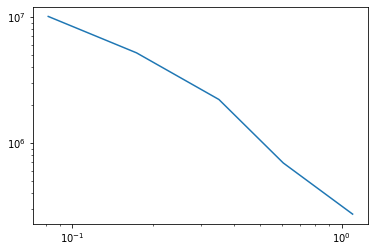

In [61]:
plt.loglog(variances,costs)

### Parameter search, T=10, dim=10

In [21]:
T=80
dim=10
seed_val_col=5
seed_val_obs=5
amm=2.
bmm=2.
cmm=50.
b=6
lz=11
l=4
N=50
tau=1/2**(l)
J=T*(2**l)
seed_val=2
B=3
np.random.seed(seed_val_obs)
collection_input=gen_model(dim,amm,bmm,cmm)
[z,v] = gen_data(T,lz,collection_input)
#[m,c] = KBF(T,l,lmax,z,collection_input)
ems=np.zeros((B,J+1,dim,1))
np.random.seed(seed_val_col)
## The with numpy.errstate argument is used to avoid any stupid warning
#EnKBF(T,l,lz,z,N,collection_input)

In [25]:
REP=100
seed_val=1
lmax=9
l0=4
N=800

current level is 5 .  4  remaining.


100% (100 of 100) |######################| Elapsed Time: 0:07:18 Time:  0:07:18


current level is 6 .  3  remaining.


100% (100 of 100) |######################| Elapsed Time: 0:19:35 Time:  0:19:35


current level is 7 .  2  remaining.


100% (100 of 100) |######################| Elapsed Time: 0:40:20 Time:  0:40:20


current level is 8 .  1  remaining.


100% (100 of 100) |######################| Elapsed Time: 1:05:48 Time:  1:05:48


current level is 9 .  0  remaining.


100% (100 of 100) |######################| Elapsed Time: 2:01:54 Time:  2:01:54


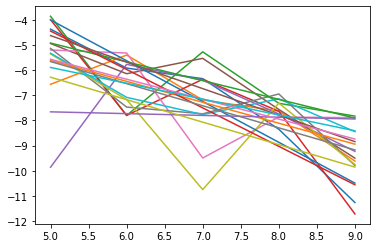

In [26]:
k1s=fit_k1(seed_val,lmax,T,l0,N,collection_input,z,lz,REP)

In [27]:
k1s

[array([[1.70216786e+01, 3.25368379e-01],
        [3.63903275e-01, 5.61900468e-01],
        [4.34332823e-01, 5.96656364e-01],
        [9.07922427e+00, 3.47123988e-01],
        [6.32873939e-03, 9.51953095e-01],
        [1.54975320e+00, 4.82044876e-01],
        [3.27150237e-01, 5.77597445e-01],
        [4.13906559e-01, 5.44196380e-01],
        [2.82716055e-01, 5.38780898e-01],
        [1.48633457e-01, 6.46582996e-01]]),
 array([5, 6, 7, 8, 9]),
 array([[ -4.3752328 ,  -6.56529182,  -3.86211839,  -3.99875231,
          -9.85851768,  -4.94402341,  -5.20346673,  -5.14004973,
          -5.36005236,  -5.33018233],
        [ -5.92139403,  -5.40413432,  -7.8037758 ,  -7.79983391,
          -5.77216253,  -6.1453763 ,  -5.32273814,  -7.46953353,
          -7.17103952,  -7.08363819],
        [ -6.34152613,  -7.18977712,  -5.2763661 ,  -6.36662132,
          -6.40369094,  -5.53427768,  -9.49223608,  -7.73813367,
         -10.74677701,  -7.76625083],
        [ -8.35006298,  -7.6274157 ,  -7.32040745

In [28]:
#########################################################

### Parameter search, T=80, dim=100

In [22]:
T=80
dim=100
seed_val_col=5
seed_val_obs=5
amm=2.
bmm=0.005
cmm=50.
b=6
lz=11
l=4
N=50
tau=1/2**(l)
J=T*(2**l)
seed_val=2
B=3
np.random.seed(seed_val_col)
collection_input=gen_model(dim,amm,bmm,cmm)
np.random.seed(seed_val_obs)
[z,v] = gen_data(T,lz,collection_input)
#[m,c] = KBF(T,l,lmax,z,collection_input)
ems=np.zeros((B,J+1,dim,1))
## The with numpy.errstate argument is used to avoid any stupid warning
#EnKBF(T,l,lz,z,N,collection_input)

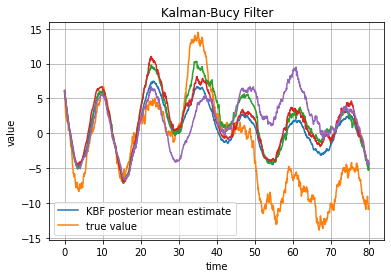

In [26]:
ind=1
ems=np.zeros((B,J+1,dim,1))
m=np.zeros((J+1,dim,1))
N=200
l=4
with np.errstate(divide='ignore'):
    m=KBF(T,l,lz,z,collection_input)[0]
    for i in range(B):
        ems[i] = EnKBF(T,l,lz,z,N,collection_input)[0]
        
        #[m2,c2] = DEnKBF(T,l,lmax,z,N,collection_input)
v1=cut(T,lz,l,v)
J=T*(2**l)
x1 = tau*np.arange(J+1)
#print(m1[:,2].T[0])
plt.plot(x1,m[:,ind],label="KBF posterior mean estimate")
plt.plot(x1,v1[:,ind],label="true value")
for i in range(B):
    plt.plot(x1,ems[i,:,ind,0])
#plt.plot(x1,m2[:,0],label="DEnKBF posterior mean estimate")
plt.xlabel('time')
plt.ylabel('value')
plt.title('Kalman-Bucy Filter')
plt.legend()
plt.grid()

In [34]:
T=80
dim=100
seed_val_col=5
seed_val_obs=5
amm=2.
bmm=0.005
cmm=50.
b=6
lz=11
l=3
N=50
tau=1/2**(l)
J=T*(2**l)
seed_val=2
B=3
np.random.seed(seed_val_col)
collection_input=gen_model(dim,amm,bmm,cmm)
zshape=(163841, 100, 1)
vshape=(163841, 100, 1)
zload=np.loadtxt('obsT80d100.txt', dtype=float)
vload=np.loadtxt('realiT80d100.txt', dtype=float)
print(np.shape(zload))
z=zload.reshape(zshape)
v=vload.reshape(vshape)
#ems=np.zeros((B,J+1,dim,1))

(163841, 100)


In [35]:

#necessary parameters: T,lz,z,N,collection_input,seed_val,l0,L,Rep
def fit_c3( T,lz,z,N,collection_input,seed_val,l0,L,Rep):
    #N = 100
    #collection_input = gen_model(dim)
    #np.random.seed(seed_val_obs)
    #z = gen_data(T,Lmax,collection_input)[0]
    
    delta_seq = np.zeros(L-l0)
    for l in range(L-l0):
        delta_seq[l] = 2**(-(l0+1+l))
    #Rep=100
    dim=collection_input[0]
    evar=np.zeros((L-l0,dim))
    np.random.seed(seed_val)
    for l in range(L-l0):
        print("Current level ",l+l0+1,". ",L-(l+l0+1),"remaining." )
        est = np.zeros((Rep,dim))
        with progressbar.ProgressBar(max_value=Rep) as bar:
            for rep in range(Rep):
                
                with np.errstate(divide='ignore'):
                    #print(T,l+l0+1,lz,N,collection_input)
                    [m,m1]=CEnKBF(T,l+l0+1,lz,z,N,collection_input)
                    est[rep] = m[-1,:,0] -m1[-1,:,0]
                    bar.update(rep)
        evar[l] = np.var(est,axis=0)
        
    bs=np.zeros((dim,2))
    x=np.log10(delta_seq)
    y=np.log10(evar)
    for i in range(dim):
        bs[i]=coef(x,(y.T)[i])
    #b=coef(abscisas,ordenadas)
    plt.plot(x,y)
    plt.plot(x,(bs[:,0].reshape(dim,1)+bs[:,1].reshape(dim,1)@x.reshape(1,L-l0)).T)

    #x = np.log10(delta_seq[4:8])
    
    
    
    #b=coef(x,y)
    #plt.plot(x,y)
    return [bs,N*10**(bs)]

In [36]:
N=50
l0=3
L=8
Rep=100

In [37]:
c3s=fit_c3(T,lz,z,N,collection_input,seed_val,l0,L,Rep)

Current level  4 .  4 remaining.


100% (100 of 100) |######################| Elapsed Time: 0:04:27 Time:  0:04:27


Current level  5 .  3 remaining.


 39% (39 of 100) |########               | Elapsed Time: 0:03:57 ETA:   0:07:18


KeyboardInterrupt: 

In [35]:
REP=25
seed_val=1
lmax=9
l0=4
N=400

current level is 5 .  4  remaining.


100% (25 of 25) |########################| Elapsed Time: 0:10:03 Time:  0:10:03


current level is 6 .  3  remaining.


100% (25 of 25) |########################| Elapsed Time: 0:19:40 Time:  0:19:40


current level is 7 .  2  remaining.


100% (25 of 25) |########################| Elapsed Time: 0:38:25 Time:  0:38:25


current level is 8 .  1  remaining.


100% (25 of 25) |########################| Elapsed Time: 1:06:45 Time:  1:06:45


current level is 9 .  0  remaining.


100% (25 of 25) |########################| Elapsed Time: 1:33:43 Time:  1:33:43


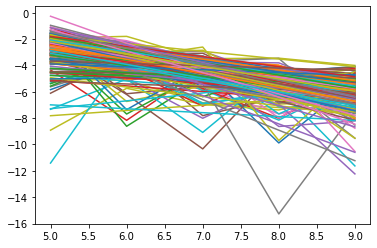

In [36]:
k1s=fit_k1(seed_val,lmax,T,l0,N,collection_input,z,lz,REP)

In [37]:
k1s

[array([[5.57681948e+00, 5.58653681e-01],
        [9.35742502e+00, 4.99101270e-01],
        [3.68507883e+00, 5.28573192e-01],
        [5.23784374e+00, 4.88553007e-01],
        [4.23383120e+00, 5.62783523e-01],
        [2.25359145e+01, 4.30430014e-01],
        [7.14351398e+01, 3.66695938e-01],
        [1.15096551e+01, 5.02975221e-01],
        [2.20566039e+00, 6.68317517e-01],
        [4.63344528e+00, 5.52928342e-01],
        [2.01340258e+01, 4.41567768e-01],
        [4.01618234e+00, 5.28853800e-01],
        [3.51671261e-01, 7.63527340e-01],
        [1.26591622e-01, 7.43107173e-01],
        [6.35462366e+00, 5.05308254e-01],
        [9.46132589e-01, 6.23232170e-01],
        [1.22544199e+00, 6.38598235e-01],
        [1.29739351e+00, 5.85243549e-01],
        [3.87845303e-01, 6.10467647e-01],
        [1.71069639e-01, 7.37976496e-01],
        [5.00936824e-01, 7.10093325e-01],
        [2.11978380e+00, 5.92876413e-01],
        [6.11252782e-02, 9.03300649e-01],
        [9.80485785e-01, 6.4628982

compare the answers 

In [31]:
k1s

[array([[5.22363217e+00, 5.51319138e-01],
        [2.00150950e+00, 5.80513400e-01],
        [1.82410366e-01, 8.37890348e-01],
        [4.81443631e-01, 7.45825927e-01],
        [8.07604602e-01, 7.33082523e-01],
        [7.60825366e+01, 3.85335788e-01],
        [2.57895743e+00, 6.08049468e-01],
        [1.98710045e+01, 4.83535140e-01],
        [1.01076228e+01, 4.13281600e-01],
        [1.13416935e+01, 4.35588388e-01],
        [1.18979902e+00, 6.28223731e-01],
        [8.86081578e+00, 4.59369999e-01],
        [2.55740647e-01, 8.03269605e-01],
        [7.80493357e-02, 9.37529783e-01],
        [2.04827101e+00, 5.82364537e-01],
        [2.66084606e-01, 7.07757618e-01],
        [2.06722316e-01, 7.80028973e-01],
        [1.54987868e+01, 4.06817388e-01],
        [5.85858599e-01, 6.85348454e-01],
        [2.35187280e-01, 7.59997957e-01],
        [2.91337099e+00, 5.42151787e-01],
        [4.69322221e+00, 4.91854961e-01],
        [1.33724234e+00, 5.51879503e-01],
        [4.30080841e-01, 7.0701776

### Error-to-cost relation

In [27]:
M=9
B=2**(M)
rho=99./100.
l0=3
pmax=8
lmax=8
N0=50

In [33]:
[estimator_mean1,estimators1,pls1]=single_term(B,N0,l0,lz,T,z,collection_input,pmax,lmax,rho)

[0, 2] 0
[0, 0] 1
[1, 0] 2
[0, 3] 3
[0, 0] 4
[0, 1] 5
[0, 0] 6
[1, 3] 7
[0, 0] 8
[0, 0] 9
[0, 0] 10
[0, 0] 11
[2, 1] 12
[0, 1] 13
[6, 0] 14
[0, 0] 15
[0, 0] 16
[0, 0] 17
[0, 1] 18
[2, 3] 19
[0, 0] 20
[0, 2] 21
[0, 0] 22
[0, 0] 23
[0, 0] 24
[0, 0] 25
[1, 3] 26
[1, 1] 27
[1, 4] 28
[2, 0] 29
[0, 0] 30
[1, 1] 31
[0, 3] 32
[1, 1] 33
[0, 4] 34
[6, 0] 35
[1, 1] 36
[0, 0] 37
[0, 1] 38
[0, 2] 39
[1, 0] 40
[0, 0] 41
[0, 1] 42
[0, 0] 43
[0, 2] 44
[0, 1] 45
[4, 0] 46
[6, 0] 47
[0, 1] 48
[0, 0] 49
[2, 1] 50
[2, 1] 51
[0, 3] 52
[0, 1] 53
[2, 4] 54
[0, 1] 55
[1, 2] 56
[2, 0] 57
[0, 0] 58
[0, 3] 59
[0, 1] 60
[1, 1] 61
[1, 0] 62
[0, 1] 63
[0, 0] 64
[0, 0] 65
[1, 1] 66
[1, 1] 67
[4, 0] 68
[0, 1] 69
[0, 2] 70
[1, 0] 71
[4, 3] 72
[0, 1] 73
[3, 0] 74
[1, 1] 75
[3, 0] 76
[3, 0] 77
[0, 1] 78
[0, 2] 79
[1, 0] 80
[5, 2] 81
[1, 0] 82
[1, 1] 83
[0, 0] 84
[0, 1] 85
[2, 0] 86
[1, 0] 87
[0, 2] 88
[0, 0] 89
[0, 0] 90
[0, 1] 91
[0, 0] 92
[0, 1] 93
[0, 1] 94
[1, 0] 95
[2, 0] 96
[1, 0] 97
[0, 1] 98
[7, 2] 99
[0, 2] 100

[0, 1] 755
[0, 0] 756
[0, 1] 757
[1, 0] 758
[0, 0] 759
[0, 2] 760
[0, 0] 761
[1, 2] 762
[1, 1] 763
[0, 0] 764
[2, 0] 765
[0, 0] 766
[0, 1] 767
[2, 0] 768
[2, 0] 769
[0, 0] 770
[1, 4] 771
[0, 2] 772
[0, 3] 773
[3, 0] 774
[0, 0] 775
[0, 0] 776
[0, 0] 777
[0, 2] 778
[2, 0] 779
[0, 4] 780
[2, 0] 781
[0, 1] 782
[0, 3] 783
[0, 0] 784
[0, 0] 785
[1, 0] 786
[0, 3] 787
[2, 0] 788
[1, 2] 789
[0, 1] 790
[0, 3] 791
[0, 1] 792
[0, 1] 793
[2, 2] 794
[2, 3] 795
[1, 2] 796
[1, 0] 797
[0, 6] 798
[1, 0] 799
[0, 0] 800
[0, 0] 801
[0, 0] 802
[0, 1] 803
[0, 0] 804
[0, 0] 805
[0, 1] 806
[1, 0] 807
[0, 0] 808
[0, 0] 809
[1, 5] 810
[0, 0] 811
[1, 0] 812
[0, 1] 813
[4, 0] 814
[1, 0] 815
[1, 3] 816
[0, 2] 817
[0, 0] 818
[5, 1] 819
[0, 1] 820
[0, 0] 821
[0, 0] 822
[0, 3] 823
[1, 0] 824
[0, 2] 825
[0, 2] 826
[0, 0] 827
[0, 1] 828
[0, 0] 829
[0, 1] 830
[3, 0] 831
[0, 0] 832
[0, 0] 833
[5, 1] 834
[1, 0] 835
[0, 0] 836
[1, 0] 837
[2, 2] 838
[0, 0] 839
[0, 1] 840
[0, 0] 841
[0, 3] 842
[1, 0] 843
[0, 1] 844
[1, 0] 845

In [34]:
estimatorsl=np.concatenate((estimators1,estimators),axis=0)
plsl=np.concatenate((pls1,pls),axis=0)

In [35]:
np.var(estimatorsl,axis=0)

array([3252.96112501, 4125.48023757, 4622.59396968, 4818.34627116,
       3612.52241748, 3872.19838394, 4249.99088476, 4815.97748   ,
       4364.9043705 , 4198.76928856, 3843.27868373, 3357.87536387,
       3972.0994918 , 3289.1966459 , 3915.7729183 , 4904.35178909,
       3899.63490134, 2635.06978154, 3358.24246946, 3630.77177627,
       3587.38724215, 3981.95230301, 3546.07808814, 4782.13116233,
       3638.64781396, 3520.53963506, 3032.62530217, 3639.08988661,
       3627.43497414, 3058.08240132, 4269.92172672, 3359.48918096,
       3373.1548519 , 4093.76073469, 3942.24877946, 4214.43619745,
       3334.03012693, 4057.08144475, 2881.07727883, 3962.13041805,
       3237.8016199 , 4062.49809795, 3457.39724137, 4447.49764172,
       4655.23037977, 3183.69851073, 3268.04507784, 3030.16500897,
       4548.69291277, 4175.03661069, 3464.28032125, 3292.18473438,
       3671.78145613, 5274.66489427, 4951.00498985, 3296.26371139,
       3599.1467053 , 2795.37124594, 3725.41312765, 3775.07486

In [36]:
cost_function(T,plsl,N0)

224940000.0

In [37]:
M=11
variancesl=np.zeros(M-6)
costsl=np.zeros(M-6)
for i in range(M-6):
    m=i+6+1
    variancesl[i]=np.var(estimatorsl[:,26])/2**m
    costsl[i]=cost_function(T,plsl[:2**m],N0)
        

Text(0, 0.5, 'cost')

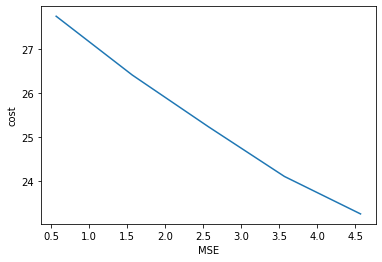

In [41]:
plt.plot(np.log2(variancesl),np.log2(costsl))
plt.xlabel("MSE")
plt.ylabel("cost")

In [ ]:
M=12
B=2**(M)
rho=99./100.
l0=0
pmax=15
lmax=15
N0=10

[estimator_mean,estimators,pls]=single_term(B,N0,l0,lz,T,z,collection_input,pmax,lmax,rho)

np.var(estimators,axis=0)

cost_function(T,pls,N0)

M=10
variances=np.zeros(M-5)
costs=np.zeros(M-5)
for i in range(M-5):
    m=i+5+1
    variances[i]=np.sum(np.var(estimators[:2**(m)]),axis=0)/2**m
    costs[i]=cost_function(T,pls[:2**m],N0)
        

plt.loglog(variances,costs)

### Parameter search, T=10, dim=2

In [40]:
T=80
dim=2
seed_val_col=5
seed_val_obs=5
amm=2.
bmm=2.
cmm=50.
b=6
lz=11
l=4
N=50
tau=1/2**(l)
J=T*(2**l)
seed_val=2
B=3
np.random.seed(seed_val_obs)
collection_input=gen_model(dim,amm,bmm,cmm)
[z,v] = gen_data(T,lz,collection_input)
#[m,c] = KBF(T,l,lmax,z,collection_input)
ems=np.zeros((B,J+1,dim,1))
np.random.seed(seed_val_col)
## The with numpy.errstate argument is used to avoid any stupid warning
#EnKBF(T,l,lz,z,N,collection_input)

In [41]:
REP=100
seed_val=1
lmax=9
l0=0
N=100

In [44]:
k1s=fit_k1(seed_val,lmax,T,l0,N,collection_input,z,lz,REP)

  2% (2 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:04

current level is 1 .  8  remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:04 Time:  0:00:04
  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:10

current level is 2 .  7  remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:08 Time:  0:00:08
  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

current level is 3 .  6  remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:17 Time:  0:00:17


current level is 4 .  5  remaining.


100% (100 of 100) |######################| Elapsed Time: 0:00:35 Time:  0:00:35


current level is 5 .  4  remaining.


 56% (56 of 100) |############           | Elapsed Time: 0:00:38 ETA:   0:00:31


KeyboardInterrupt: 

In [27]:
k1s

[array([[1.70216786e+01, 3.25368379e-01],
        [3.63903275e-01, 5.61900468e-01],
        [4.34332823e-01, 5.96656364e-01],
        [9.07922427e+00, 3.47123988e-01],
        [6.32873939e-03, 9.51953095e-01],
        [1.54975320e+00, 4.82044876e-01],
        [3.27150237e-01, 5.77597445e-01],
        [4.13906559e-01, 5.44196380e-01],
        [2.82716055e-01, 5.38780898e-01],
        [1.48633457e-01, 6.46582996e-01]]),
 array([5, 6, 7, 8, 9]),
 array([[ -4.3752328 ,  -6.56529182,  -3.86211839,  -3.99875231,
          -9.85851768,  -4.94402341,  -5.20346673,  -5.14004973,
          -5.36005236,  -5.33018233],
        [ -5.92139403,  -5.40413432,  -7.8037758 ,  -7.79983391,
          -5.77216253,  -6.1453763 ,  -5.32273814,  -7.46953353,
          -7.17103952,  -7.08363819],
        [ -6.34152613,  -7.18977712,  -5.2763661 ,  -6.36662132,
          -6.40369094,  -5.53427768,  -9.49223608,  -7.73813367,
         -10.74677701,  -7.76625083],
        [ -8.35006298,  -7.6274157 ,  -7.32040745

### Error-to-cost relation

$\alpha=99/100$

In [46]:
M=11
B=2**(M)
rho=99./100.
l0=0
pmax=8
lmax=11
N0=10

In [47]:
[estimator_mean,estimators,pls]=single_term(B,N0,l0,lz,T,z,collection_input,pmax,lmax,rho)

[0, 1] 0
[0, 0] 1
[1, 1] 2
[4, 0] 3
[0, 0] 4
[2, 1] 5
[0, 2] 6
[1, 1] 7
[2, 4] 8
[0, 0] 9
[1, 4] 10
[0, 0] 11
[0, 0] 12
[0, 2] 13
[2, 0] 14
[1, 2] 15
[0, 0] 16
[0, 0] 17
[2, 0] 18
[0, 3] 19
[0, 0] 20
[0, 1] 21
[0, 0] 22
[0, 3] 23
[2, 4] 24
[1, 0] 25
[1, 1] 26
[1, 1] 27
[0, 0] 28
[0, 0] 29
[0, 0] 30
[0, 2] 31
[1, 3] 32
[2, 0] 33
[4, 1] 34
[0, 0] 35
[1, 0] 36
[0, 0] 37
[1, 2] 38
[0, 1] 39
[2, 0] 40
[0, 0] 41
[1, 2] 42
[4, 2] 43
[1, 1] 44
[1, 0] 45
[1, 0] 46
[2, 0] 47
[2, 1] 48
[1, 2] 49
[1, 1] 50
[1, 4] 51
[0, 1] 52
[1, 1] 53
[0, 3] 54
[0, 1] 55
[0, 2] 56
[0, 3] 57
[0, 0] 58
[0, 0] 59
[1, 1] 60
[0, 1] 61
[0, 1] 62
[0, 0] 63
[0, 0] 64
[0, 0] 65
[0, 0] 66
[1, 1] 67
[1, 2] 68
[0, 1] 69
[1, 3] 70
[0, 0] 71
[0, 0] 72
[2, 3] 73
[1, 0] 74
[0, 0] 75
[1, 0] 76
[2, 0] 77
[0, 4] 78
[0, 0] 79
[0, 2] 80
[1, 2] 81
[3, 0] 82
[4, 0] 83
[3, 1] 84
[0, 0] 85
[0, 1] 86
[0, 4] 87
[1, 0] 88
[2, 0] 89
[7, 1] 90
[2, 0] 91
[3, 0] 92
[0, 2] 93
[0, 1] 94
[0, 3] 95
[0, 1] 96
[1, 0] 97
[1, 0] 98
[0, 3] 99
[0, 0] 100

[4, 0] 755
[1, 0] 756
[2, 0] 757
[1, 1] 758
[2, 5] 759
[0, 1] 760
[0, 0] 761
[7, 0] 762
[3, 1] 763
[0, 1] 764
[1, 0] 765
[1, 4] 766
[0, 0] 767
[0, 1] 768
[1, 0] 769
[2, 0] 770
[2, 1] 771
[0, 4] 772
[0, 0] 773
[2, 0] 774
[0, 1] 775
[1, 1] 776
[1, 2] 777
[1, 1] 778
[0, 0] 779
[3, 1] 780
[0, 0] 781
[0, 0] 782
[0, 3] 783
[2, 2] 784
[5, 1] 785
[2, 3] 786
[0, 1] 787
[2, 1] 788
[0, 3] 789
[1, 1] 790
[1, 1] 791
[0, 0] 792
[0, 0] 793
[1, 0] 794
[0, 0] 795
[0, 1] 796
[0, 0] 797
[1, 0] 798
[1, 0] 799
[3, 2] 800
[2, 3] 801
[0, 0] 802
[1, 1] 803
[1, 0] 804
[0, 0] 805
[1, 1] 806
[4, 3] 807
[1, 0] 808
[0, 1] 809
[1, 1] 810
[0, 0] 811
[3, 3] 812
[0, 1] 813
[0, 1] 814
[3, 4] 815
[2, 0] 816
[0, 2] 817
[0, 2] 818
[0, 0] 819
[3, 0] 820
[0, 1] 821
[0, 0] 822
[2, 0] 823
[0, 0] 824
[0, 2] 825
[1, 0] 826
[1, 0] 827
[1, 2] 828
[1, 1] 829
[0, 0] 830
[1, 0] 831
[1, 1] 832
[2, 2] 833
[1, 0] 834
[0, 0] 835
[0, 4] 836
[0, 2] 837
[0, 0] 838
[3, 0] 839
[0, 0] 840
[4, 2] 841
[0, 2] 842
[0, 0] 843
[0, 0] 844
[1, 0] 845

[0, 0] 1460
[1, 0] 1461
[1, 2] 1462
[0, 2] 1463
[2, 1] 1464
[2, 8] 1465
[1, 0] 1466
[0, 0] 1467
[2, 1] 1468
[3, 3] 1469
[0, 1] 1470
[3, 1] 1471
[0, 2] 1472
[1, 0] 1473
[0, 1] 1474
[1, 1] 1475
[0, 4] 1476
[0, 1] 1477
[1, 0] 1478
[2, 0] 1479
[3, 2] 1480
[0, 0] 1481
[0, 0] 1482
[1, 2] 1483
[4, 0] 1484
[5, 0] 1485
[2, 3] 1486
[3, 1] 1487
[1, 1] 1488
[0, 0] 1489
[1, 3] 1490
[0, 0] 1491
[3, 0] 1492
[2, 0] 1493
[1, 0] 1494
[0, 9] 1495
[0, 0] 1496
[2, 2] 1497
[2, 0] 1498
[0, 0] 1499
[0, 1] 1500
[0, 0] 1501
[1, 1] 1502
[3, 0] 1503
[0, 3] 1504
[0, 0] 1505
[2, 0] 1506
[0, 1] 1507
[1, 6] 1508
[0, 1] 1509
[0, 0] 1510
[2, 3] 1511
[0, 2] 1512
[6, 3] 1513
[3, 2] 1514
[4, 0] 1515
[1, 2] 1516
[0, 0] 1517
[0, 4] 1518
[0, 1] 1519
[5, 0] 1520
[2, 0] 1521
[0, 0] 1522
[0, 9] 1523
[0, 0] 1524
[0, 0] 1525
[1, 2] 1526
[0, 0] 1527
[0, 1] 1528
[0, 1] 1529
[0, 0] 1530
[2, 0] 1531
[2, 2] 1532
[0, 2] 1533
[1, 7] 1534
[1, 0] 1535
[1, 0] 1536
[0, 1] 1537
[0, 2] 1538
[0, 3] 1539
[2, 0] 1540
[0, 4] 1541
[1, 0] 1542
[1, 

In [99]:
#np.savetxt('estimatorsd2T80a099.txt', estimators, fmt='%f')
#np.savetxt('plsd2T80a099.txt', pls, fmt='%i')
estload=np.loadtxt('estimatorsd2T80a099.txt', dtype="float")
plsload=np.loadtxt('plsd2T80a099.txt', dtype="int")

In [57]:
np.var(estimators,axis=0)

array([146.77743226, 423.41506434])

In [59]:
cost_function(T,pls,N0)

48016000.0

In [60]:
M=11
s=6
variances=np.zeros(M-s)
costs=np.zeros(M-s)
for i in range(M-s):
    m=i+s+1
    variances[i]=np.var(estimators[:,0])/2**m
    costs[i]=cost_function(T,pls[:2**m],N0)
        

$\alpha=3/4$

In [62]:
M=11
B=2**(M)
rho=3./4.
l0=0
pmax=8
lmax=11
N0=10

In [100]:
[estimator_mean,estimators,pls]=single_term(B,N0,l0,lz,T,z,collection_input,pmax,lmax,rho)

In [101]:
#np.savetxt('estimatorsd2T80a075.txt', estimators, fmt='%f')
#np.savetxt('plsd2T80a075.txt', pls, fmt='%i')
estload075=np.loadtxt('estimatorsd2T80a075.txt', dtype="float")
plsload075=np.loadtxt('plsd2T80a075.txt', dtype="int")

In [69]:
np.var(estimators,axis=0)

array([169.14010291, 276.12326649])

In [70]:
cost_function(T,pls,N0)

277032000.0

In [71]:
M=11
s=6
variances075=np.zeros(M-s)
costs075=np.zeros(M-s)
for i in range(M-s):
    m=i+s+1
    variances075[i]=np.var(estload075[:,0])/2**m
    
    costs075[i]=cost_function(T,plsload075[:2**m],N0)
    costs075[i]=cost_function(T,plsload075[:2**m],N0)

$\alpha=3/2$

In [76]:
M=11
B=2**(M)
rho=3./2.
l0=0
pmax=8
lmax=11
N0=10

In [106]:
[estimator_mean,estimators,pls]=single_term(B,N0,l0,lz,T,z,collection_input,pmax,lmax,rho)

In [102]:
#np.savetxt('estimatorsd2T80a1p5.txt', estimators, fmt='%f')
#np.savetxt('plsd2T80a1p5.txt', pls, fmt='%i')
estload1p5=np.loadtxt('estimatorsd2T80a1p5.txt', dtype="float")
plsload1p5=np.loadtxt('plsd2T80a1p5.txt', dtype="int")

In [81]:
np.var(estimators,axis=0)

array([ 299.21575452, 1379.08250678])

In [82]:
cost_function(T,pls,N0)

9550400.0

In [86]:
M=11
s=6
variances1p5=np.zeros(M-s)
costs1p5=np.zeros(M-s)
for i in range(M-s):
    m=i+s+1
    variances1p5[i]=np.var(estload1p5[:,0])/2**m
    
    costs1p5[i]=cost_function(T,plsload1p5[:2**m],N0)
    costs1p5[i]=cost_function(T,plsload1p5[:2**m],N0)

$\alpha=2$

In [89]:
M=11
B=2**(M)
rho=2.
l0=0
pmax=8
lmax=11
N0=10

In [90]:
[estimator_mean,estimators,pls]=single_term(B,N0,l0,lz,T,z,collection_input,pmax,lmax,rho)

[1, 0] 0
[0, 0] 1
[0, 0] 2
[0, 2] 3
[0, 0] 4
[2, 0] 5
[0, 0] 6
[0, 0] 7
[0, 0] 8
[0, 0] 9
[0, 1] 10
[0, 0] 11
[0, 1] 12
[0, 1] 13
[0, 2] 14
[3, 0] 15
[0, 1] 16
[0, 1] 17
[0, 0] 18
[0, 0] 19
[1, 0] 20
[0, 0] 21
[0, 0] 22
[0, 0] 23
[0, 0] 24
[0, 1] 25
[0, 0] 26
[0, 0] 27
[0, 2] 28
[0, 0] 29
[0, 0] 30
[0, 1] 31
[1, 1] 32
[0, 1] 33
[0, 1] 34
[0, 0] 35
[0, 1] 36
[1, 0] 37
[0, 4] 38
[0, 0] 39
[0, 0] 40
[0, 0] 41
[0, 0] 42
[0, 2] 43
[0, 0] 44
[1, 0] 45
[0, 0] 46
[0, 0] 47
[2, 0] 48
[1, 1] 49
[0, 0] 50
[0, 0] 51
[1, 2] 52
[0, 1] 53
[0, 0] 54
[1, 1] 55
[0, 0] 56
[0, 0] 57
[0, 1] 58
[0, 0] 59
[0, 0] 60
[0, 0] 61
[0, 0] 62
[0, 0] 63
[0, 0] 64
[1, 0] 65
[0, 1] 66
[1, 0] 67
[0, 2] 68
[1, 0] 69
[0, 1] 70
[1, 0] 71
[0, 0] 72
[0, 1] 73
[0, 0] 74
[1, 0] 75
[0, 1] 76
[0, 2] 77
[0, 1] 78
[0, 0] 79
[0, 0] 80
[0, 0] 81
[1, 0] 82
[0, 0] 83
[0, 0] 84
[0, 0] 85
[0, 1] 86
[0, 1] 87
[1, 1] 88
[0, 1] 89
[1, 0] 90
[1, 1] 91
[0, 0] 92
[0, 1] 93
[0, 0] 94
[0, 0] 95
[0, 0] 96
[0, 0] 97
[0, 0] 98
[0, 1] 99
[0, 0] 100

[1, 0] 759
[0, 0] 760
[3, 0] 761
[0, 0] 762
[0, 1] 763
[0, 0] 764
[0, 0] 765
[0, 0] 766
[0, 0] 767
[0, 2] 768
[0, 0] 769
[0, 0] 770
[0, 1] 771
[0, 0] 772
[0, 1] 773
[0, 1] 774
[0, 0] 775
[0, 2] 776
[0, 0] 777
[0, 0] 778
[0, 2] 779
[0, 1] 780
[0, 1] 781
[0, 0] 782
[1, 0] 783
[1, 2] 784
[0, 1] 785
[0, 0] 786
[0, 0] 787
[2, 0] 788
[1, 0] 789
[0, 0] 790
[0, 0] 791
[1, 0] 792
[0, 0] 793
[0, 1] 794
[0, 0] 795
[0, 0] 796
[0, 0] 797
[0, 0] 798
[1, 0] 799
[0, 0] 800
[0, 0] 801
[0, 0] 802
[1, 0] 803
[0, 1] 804
[0, 0] 805
[1, 0] 806
[0, 0] 807
[0, 0] 808
[0, 2] 809
[1, 0] 810
[0, 0] 811
[0, 0] 812
[0, 0] 813
[0, 0] 814
[1, 1] 815
[0, 0] 816
[0, 1] 817
[3, 0] 818
[0, 0] 819
[0, 0] 820
[1, 2] 821
[0, 1] 822
[2, 1] 823
[3, 0] 824
[0, 0] 825
[0, 0] 826
[0, 0] 827
[0, 0] 828
[0, 0] 829
[0, 0] 830
[0, 0] 831
[1, 0] 832
[0, 0] 833
[1, 0] 834
[0, 1] 835
[0, 0] 836
[1, 0] 837
[0, 0] 838
[0, 0] 839
[0, 0] 840
[0, 0] 841
[0, 0] 842
[0, 0] 843
[0, 0] 844
[1, 0] 845
[1, 0] 846
[0, 1] 847
[0, 0] 848
[1, 1] 849

[1, 1] 1462
[0, 0] 1463
[0, 1] 1464
[0, 0] 1465
[0, 0] 1466
[0, 0] 1467
[0, 0] 1468
[0, 0] 1469
[1, 1] 1470
[0, 0] 1471
[0, 0] 1472
[1, 0] 1473
[0, 0] 1474
[0, 0] 1475
[0, 3] 1476
[0, 2] 1477
[0, 0] 1478
[1, 1] 1479
[0, 0] 1480
[0, 0] 1481
[1, 0] 1482
[0, 0] 1483
[0, 0] 1484
[1, 1] 1485
[0, 0] 1486
[0, 0] 1487
[1, 1] 1488
[0, 2] 1489
[0, 0] 1490
[0, 0] 1491
[3, 0] 1492
[1, 2] 1493
[0, 0] 1494
[0, 0] 1495
[0, 0] 1496
[0, 0] 1497
[1, 1] 1498
[0, 1] 1499
[0, 0] 1500
[0, 0] 1501
[2, 0] 1502
[0, 0] 1503
[0, 1] 1504
[0, 0] 1505
[0, 1] 1506
[0, 0] 1507
[0, 0] 1508
[0, 0] 1509
[0, 0] 1510
[0, 0] 1511
[0, 0] 1512
[0, 0] 1513
[0, 0] 1514
[0, 0] 1515
[1, 0] 1516
[0, 0] 1517
[0, 1] 1518
[0, 0] 1519
[1, 0] 1520
[1, 0] 1521
[0, 0] 1522
[0, 0] 1523
[1, 0] 1524
[0, 0] 1525
[0, 0] 1526
[2, 1] 1527
[0, 0] 1528
[0, 2] 1529
[0, 0] 1530
[0, 0] 1531
[0, 0] 1532
[0, 0] 1533
[0, 0] 1534
[0, 0] 1535
[0, 0] 1536
[0, 2] 1537
[0, 0] 1538
[0, 0] 1539
[0, 1] 1540
[0, 0] 1541
[0, 0] 1542
[0, 0] 1543
[0, 0] 1544
[0, 

In [103]:
#np.savetxt('estimatorsd2T80a2.txt', estimators, fmt='%f')
#np.savetxt('plsd2T80a2.txt', pls, fmt='%i')
estload2=np.loadtxt('estimatorsd2T80a2.txt', dtype="float")
plsload2=np.loadtxt('plsd2T80a2.txt', dtype="int")

In [92]:
np.var(estimators,axis=0)

array([368.03619247, 580.63802696])

In [93]:
cost_function(T,pls,N0)

4409600.0

In [94]:
M=11
s=6
variances2=np.zeros(M-s)
costs2=np.zeros(M-s)
for i in range(M-s):
    m=i+s+1
    variances2[i]=np.var(estload2[:,0])/2**m
    
    costs2[i]=cost_function(T,plsload2[:2**m],N0)
    costs2[i]=cost_function(T,plsload2[:2**m],N0)

[20.68035936 -1.27848606] [22.89260419 -1.49236267] [20.40118504 -1.01429238] [19.57776035 -1.00458379]


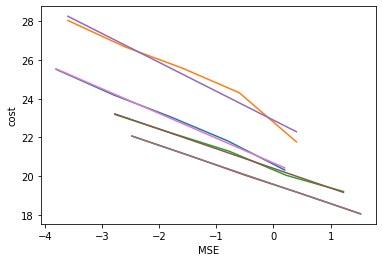

In [104]:
plt.plot(np.log2(variances),np.log2(costs))
plt.plot(np.log2(variances075),np.log2(costs075))
plt.plot(np.log2(variances1p5),np.log2(costs1p5))
plt.plot(np.log2(variances2),np.log2(costs2))


plt.xlabel("MSE")
b075=coef(np.log2(variances075),np.log2(costs075))
b1p5=coef(np.log2(variances1p5),np.log2(costs1p5))
b2=coef(np.log2(variances2),np.log2(costs2))
plt.ylabel("cost")
plt.plot(np.log2(variances075),b075[0]+b075[1]*np.log2(variances075))
plt.plot(np.log2(variances1p5),b1p5[0]+b1p5[1]*np.log2(variances1p5))
plt.plot(np.log2(variances),b[0]+b[1]*np.log2(variances))
plt.plot(np.log2(variances2),b2[0]+b2[1]*np.log2(variances2))
print(b,b075,b1p5,b2)

In [105]:
print(np.mean(estload,axis=0),np.mean(estload075,axis=0),np.mean(estload1p5,axis=0),np.mean(estload2,axis=0))

[-3.91671217  3.71723692] [-3.78891112  3.11570927] [-3.98424808  3.7577826 ] [-3.81041265  3.30761973]


### Rates of the variances 

dim=2, T=80

In [107]:
T=80
dim=2
seed_val_col=5
seed_val_obs=5
amm=2.
bmm=2.
cmm=50.
b=6
lz=11
l=4
N=50
tau=1/2**(l)
J=T*(2**l)
seed_val=2
B=3
np.random.seed(seed_val_obs)
collection_input=gen_model(dim,amm,bmm,cmm)
[z,v] = gen_data(T,lz,collection_input)
#[m,c] = KBF(T,l,lmax,z,collection_input)
ems=np.zeros((B,J+1,dim,1))
np.random.seed(seed_val_col)
## The with numpy.errstate argument is used to avoid any stupid warning
#EnKBF(T,l,lz,z,N,collection_input)

#### For the number of particles discretization

In [113]:
Rep=100
pmax=6
N0=20
l=2
l0=0
dim=collection_input[0]
samples=np.zeros((Rep,dim))
sm=np.zeros((pmax,dim))

for p in range(pmax):
    p+=1
    for i in range(Rep):
        samples[i]=plevels(p,N0,l,l0,lz,T,z,collection_input).T
    sm[p-1]=np.mean(samples**2,axis=0)        

[-5.35949764 -0.92260987]


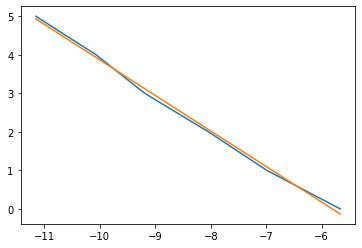

In [119]:
index=1
particles=np.array([2**p for p in range(pmax)])
plt.plot(np.log2(sm[:,index]),np.log2(particles))
bs=coef(np.log2(sm[:,index]),np.log2(particles))
plt.plot(np.log2(sm[:,index]),bs[0]+bs[1]*np.log2(sm[:,index]))
print(bs)

#### For the time discretization

In [129]:
Rep=500
lmax=7
N0=30
p=1
l0=0
dim=collection_input[0]
samples=np.zeros((Rep,dim))
sm=np.zeros((lmax-l0,dim))

for l in range(lmax-l0):
    l+=1
    for i in range(Rep):
        samples[i]=plevels(p,N0,l,l0,lz,T,z,collection_input).T
    sm[l-1]=np.mean(samples**2,axis=0)        

[6.64980463 0.96542616]


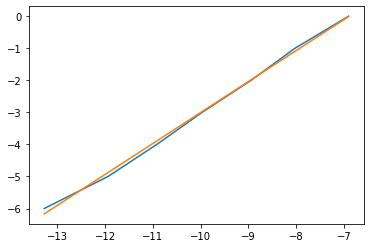

In [132]:
index=0
tdiscretization=np.array([2**(-l) for l in range(lmax-l0)])
plt.plot(np.log2(sm[:,index]),np.log2(tdiscretization))
bs=coef(np.log2(sm[:,index]),np.log2(tdiscretization))
plt.plot(np.log2(sm[:,index]),bs[0]+bs[1]*np.log2(sm[:,index]))
print(bs)

### Parameter search, T=10, dim=1000

In [ ]:
T=5
dim=1000
seed_val_col=5
seed_val_obs=5
amm=2.
bmm=200
cmm=50.
b=6
lz=10
l=4
N=50
tau=1/2**(l)
J=T*(2**l)
seed_val=2
B=3
np.random.seed(seed_val_col)
collection_input=gen_model(dim,amm,bmm,cmm)
np.random.seed(seed_val_obs)
[z,v] = gen_data(T,lz,collection_input)
#[m,c] = KBF(T,l,lmax,z,collection_input)
ems=np.zeros((B,J+1,dim,1))
## The with numpy.errstate argument is used to avoid any stupid warning


In [61]:
zshape=z.shape
vshape=v.shape
print(z.shape)
print(v.shape)
zreshaped=z.reshape(z.shape[0],-1)
vreshaped=v.reshape(v.shape[0],-1)
#np.savetxt('obs.txt', zreshaped, fmt='%f')
#np.savetxt('reali.txt', vreshaped, fmt='%f')

(5121, 1000, 1)
(5121, 1000, 1)


In [63]:
zshape=(5121, 1000, 1)
vshape=(5121, 1000, 1)
zload=np.loadtxt('obsT5d1000.txt', dtype=float)
vload=np.loadtxt('realiT5d1000.txt', dtype=float)
print(np.shape(zload))
z=zload.reshape(zshape)
v=vload.reshape(vshape)

(5121, 1000)


In [59]:
np.shape(zload)

(20481, 1000)

In [65]:
l=4
N=50
#EnKBF(T,l,lz,z,N,collection_input)

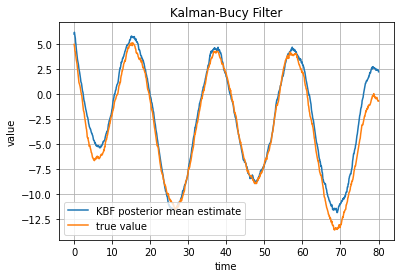

In [68]:
ind=20
ems=np.zeros((B,J+1,dim,1))
m=np.zeros((J+1,dim,1))
N=800
l=8
with np.errstate(divide='ignore'):
    m=KBF(T,l,lz,z,collection_input)[0]
    #for i in range(B):
        #ems[i]=EnKBF(T,l,lz,z,N,collection_input)[0]
        
        #[m2,c2] = DEnKBF(T,l,lmax,z,N,collection_input)
v1=cut(T,lz,l,v)
J=T*(2**l)
x1 = tau*np.arange(J+1)
#print(m1[:,2].T[0])
plt.plot(x1,m[:,ind],label="KBF posterior mean estimate")
plt.plot(x1,v1[:,ind],label="true value")
#for i in range(B):
    #plt.plot(x1,ems[i,:,ind,0])
#plt.plot(x1,m2[:,0],label="DEnKBF posterior mean estimate")
plt.xlabel('time')
plt.ylabel('value')
plt.title('Kalman-Bucy Filter')
plt.legend()
plt.grid()

In [24]:
T=80
dim=100
seed_val_col=5
seed_val_obs=5
amm=2.
bmm=0.005
cmm=50.
b=6
lz=11
l=3
N=50
tau=1/2**(l)
J=T*(2**l)
seed_val=2
B=3
np.random.seed(seed_val_col)
collection_input=gen_model(dim,amm,bmm,cmm)
zshape=(163841, 100, 1)
vshape=(163841, 100, 1)
zload=np.loadtxt('obs.txt', dtype=float)
vload=np.loadtxt('reali.txt', dtype=float)
print(np.shape(zload))
z=zload.reshape(zshape)
v=vload.reshape(vshape)
#ems=np.zeros((B,J+1,dim,1))

(163841, 100)
